# Data Loading and Preprocessing

   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  ...  popUpWidnow  Iframe  \

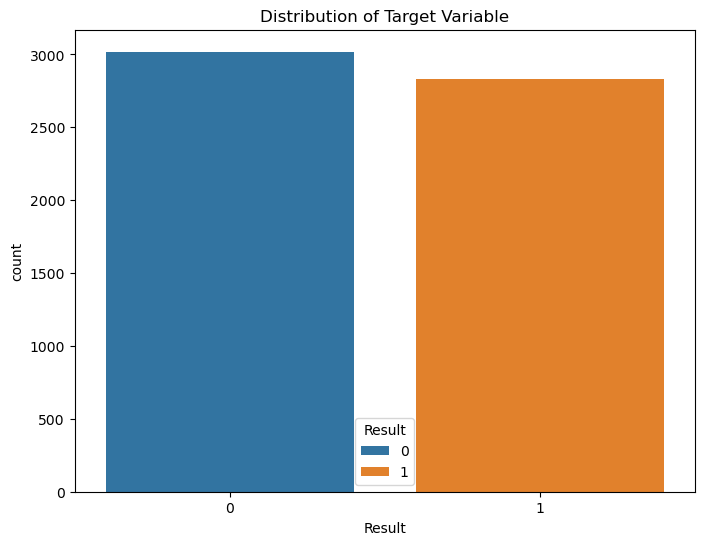

Favicon      popUpWidnow    0.933145
popUpWidnow  Favicon        0.933145
dtype: float64


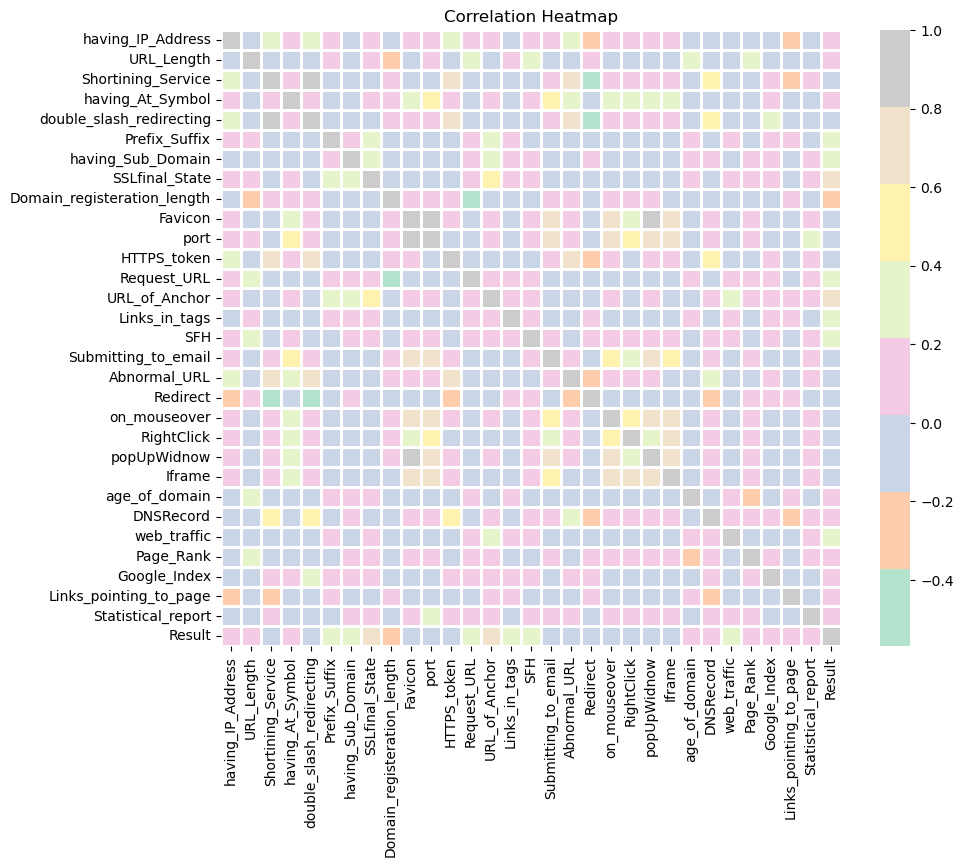

Features encoded for Naive Bayes:
   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                  0           2                   1                 1   
1                  1           2                   1                 1   
2                  1           1                   1                 1   
3                  1           1                   1                 1   
4                  1           1                   0                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                         0              0                  0               0   
1                         1              0                  1               2   
2                         1              0                  0               0   
3                         1              0                  0               0   
4                         1              0                  2               2   

   Domain_registeration_length  Fa

In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

#The ARFF file is a format used for machine learning datasets, usually it contains both the data and metadata (like feature names and types).
# In this case, we will use the scipy library to load the ARFF file.

# Load the ARFF file.
data, meta = arff.loadarff('./dataset/Training Dataset.arff')

#Since is in arff format, we need to convert it to a pandas DataFrame
df = pd.DataFrame(data)
# Assign the column names from the metadata
df.columns = meta.names()
# Convert byte strings to regular strings
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)
# Convert all columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Display the DataFrame
print(df.head())
print(df.info())
#print(df.shape)
#print(df.describe())

# The features are all discrete or binary,
# The discrete features varies between -1, 0, and 1, and are all ordinal. So I don't need create dummy variables.

# Binary features: convert {-1,1} to {0,1}
binary_features = ['having_IP_Address', 'Shortining_Service', 'having_At_Symbol',
                   'double_slash_redirecting', 'Prefix_Suffix', 'Domain_registeration_length',
                   'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'Submitting_to_email',
                   'Abnormal_URL', 'on_mouseover', 'RightClick', 'Iframe', 'age_of_domain',
                   'DNSRecord', 'Page_Rank', 'Google_Index', 'Statistical_report', 'Result']

for feature in binary_features:
    if feature in df.columns:
        df[feature] = df[feature].map({-1: 0, 1: 1})

# Ordinal features: convert {-1,0,1} to {0,1,2}
ordinal_features = ['URL_Length', 'having_Sub_Domain', 'SSLfinal_State', 'URL_of_Anchor',
                    'Links_in_tags', 'SFH', 'web_traffic', 'Links_pointing_to_page']

for feature in ordinal_features:
    if feature in df.columns:
        df[feature] = df[feature].map({-1: 0, 0: 1, 1: 2})

if 'Redirect' in df.columns:
    df['Redirect'] = df['Redirect']

# Check if there are any duplicates and missing values
print('Initial shape of the dataset:', df.shape)
print('The dataset contains ', df.duplicated().sum(), 'duplicati')
df = df.drop_duplicates()
df = df.dropna()
print('Final shape of the dataset: ', df.shape)

# Distribution of the target variable
print(df['Result'].value_counts(normalize=True))
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Result", hue="Result")
plt.title('Distribution of Target Variable')
plt.show()

#Heatmap and feature dropping
corr_matrix = df.corr()
threshold = 0.9
corr_pairs = corr_matrix.unstack()
high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)]
print(high_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='Pastel2', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

# Drop highly correlated features
df = df.drop('popUpWidnow', axis=1)
plt.close()
  
print("Features encoded for Naive Bayes:")
print(df.head())

# Data Splitting

In [ ]:
# Execute a shuffle to ensure that the data is randomly distributed
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Divide the dataset into features and target
X, y = df.drop('Result', axis=1), df['Result']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For model selection, divide the training set into training and validation sets
X_tr, X_dev, y_tr, y_dev = train_test_split(X_train, y_train, test_size=0.125, random_state=21)  # 0.8 * 0.125 = 0.1

""" Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

print("Scaled features:")
print(X_train[:5])  # Display first 5 rows of scaled features
"""

# Display the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Testing labels shape: {y_test.shape}")

Training set shape: (4679, 29), Testing set shape: (1170, 29)
Training labels shape: (4679,), Testing labels shape: (1170,)


# Model Selection and Hyperparameter Tuning

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Validation best score: 0.9235559334818613
Development set F1 Score: 0.9197308381390147


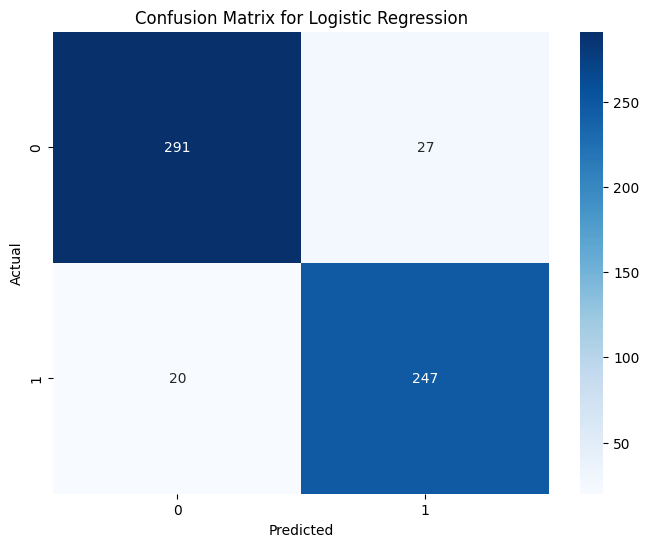

In [ ]:
# CLassification algorithms

# Logistic Regression
model = LogisticRegression()

# Parameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
}

# Usisng GridSearchCV for hyperparameter tuning, with 5-fold cross-validation and f1 for scoring
gridCV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
# Fit the model
gridCV.fit(X_tr, y_tr)

# Model assessment on development set
y_pred_dev = gridCV.predict(X_dev)

# Best estimator
print("Best parameters for Logistic Regression:", gridCV.best_params_)
print("Validation best score:", gridCV.best_score_)
print("Development set F1 Score:", f1_score(y_dev, y_pred_dev, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred_dev)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best parameters for KNN: {'n_neighbors': 7}
Validation best score: 0.9342927556209999
Development set F1 Score: 0.9419124771202322


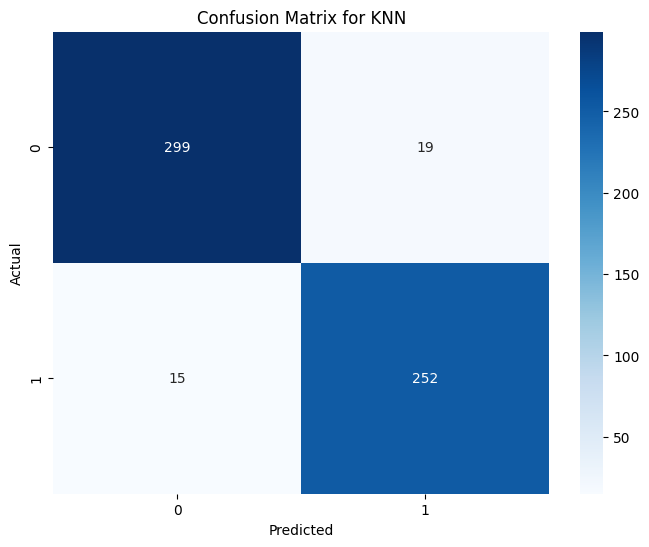

In [ ]:
# K-Nearest Neighbors
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Testing neighbors from 1 to 20
}
gridCV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
gridCV.fit(X_tr, y_tr)

# Model assessment on development set
y_pred_dev = gridCV.predict(X_dev)
print("Best parameters for KNN:", gridCV.best_params_)
print("Validation best score:", gridCV.best_score_)
print("Development set F1 Score:", f1_score(y_dev, y_pred_dev, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred_dev)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Naive Bayes categorical: MultinomialNB(alpha=3, fit_prior=False)
Validation best score: 0.8768478690049599
Development set F1 Score: 0.8652142640343454


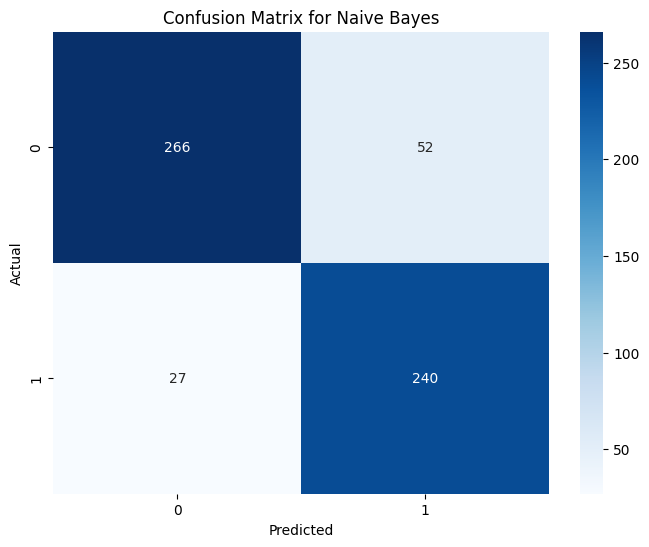

In [ ]:
# Naive Bayes
# For ordinal/discrete features, use CategoricalNB (if scikit-learn >= 0.22), otherwise use GaussianNB as fallback.
model = MultinomialNB()

param_list = {
    'alpha': [0.1, 1, 2, 3],  # Smoothing parameter
    'fit_prior': [True, False],  # Whether to learn class prior probabilities or not
}

gridCV = GridSearchCV(estimator=model,param_grid=param_list, cv=5, scoring='f1_weighted')
gridCV.fit(X_tr, y_tr)

# Model assessment on development set
y_pred_dev = gridCV.predict(X_dev)
print("Naive Bayes categorical:", gridCV.best_estimator_)
print("Validation best score:", gridCV.best_score_)
print("Development set F1 Score:", f1_score(y_dev, y_pred_dev, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred_dev)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best parameters for SVM: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Validation best score: 0.9477286354827372
Development set F1 Score: 0.9435980459308152


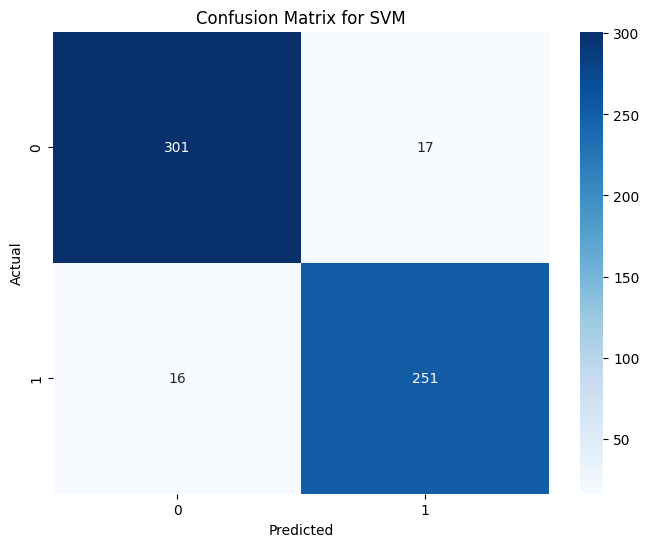

In [ ]:
# Support Vector Machine
model = SVC() # SVC is a Support Vector Classifier
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
}
gridCV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
gridCV.fit(X_tr, y_tr)
# Model assessment on development set
y_pred_dev = gridCV.predict(X_dev)
print("Best parameters for SVM:", gridCV.best_params_)
print("Validation best score:", gridCV.best_score_)
print("Development set F1 Score:", f1_score(y_dev, y_pred_dev, average='weighted'))
# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred_dev)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best parameters for MLP Classifier: {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': 55, 'solver': 'adam'}
Validation best score: 0.9408940776491292
Development set F1 Score: 0.9538390850639578


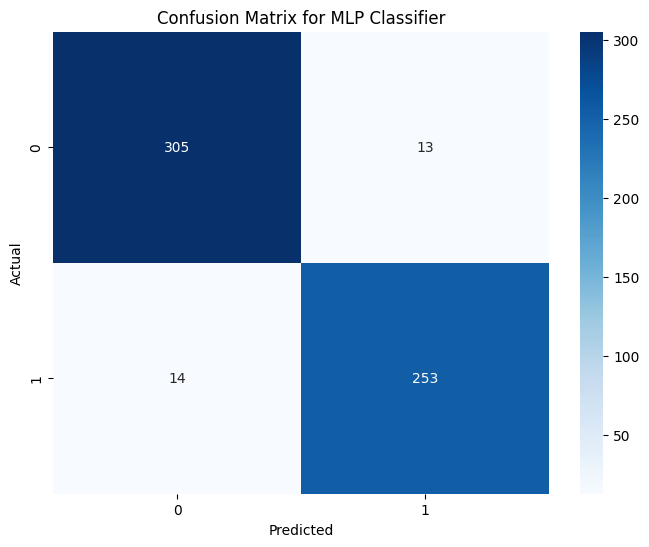

In [ ]:
# Neural Network
model = MLPClassifier(max_iter=500)
param_grid = {
    'hidden_layer_sizes': [1,55],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.00005, 0.005],
}
gridCV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
gridCV.fit(X_tr, y_tr)
# Model assessment on development set
y_pred_dev = gridCV.predict(X_dev)
print("Best parameters for MLP Classifier:", gridCV.best_params_)
print("Validation best score:", gridCV.best_score_)
print("Development set F1 Score:", f1_score(y_dev, y_pred_dev, average='weighted'))
# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred_dev)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for MLP Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Final Model Evaluation on Test Set

Best model selected: MLPClassifier(activation='tanh', alpha=0.005, hidden_layer_sizes=55,
              max_iter=500)
Training set F1 Score: 0.9788382489112636
Test set accuracy: 0.947008547008547
Test set F1 Score: 0.9470015744489427
Test set Precision: 0.9470444548388164
Test set Recall: 0.947008547008547


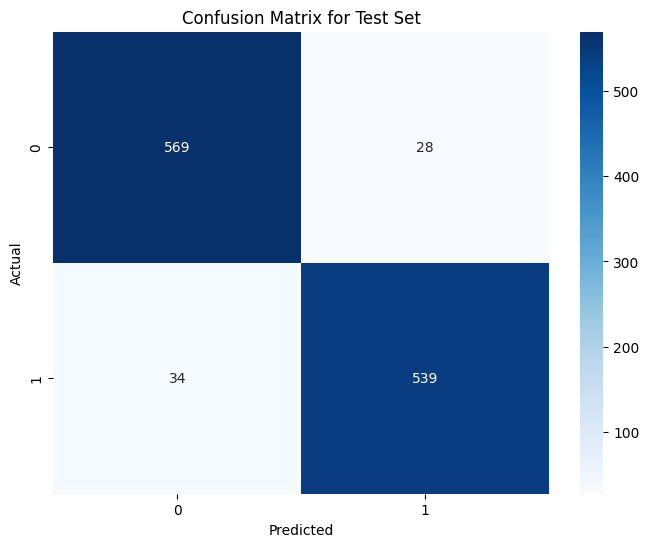

In [ ]:
# Final Model Selection
# After evaluating all models, we can select the best one based on the F1 score on the development set.
print("Best model selected:", gridCV.best_estimator_)

best_model = gridCV.best_estimator_ #SVC(C=10, gamma=0.1)

# Train the best model on the full training set
best_model.fit(X_train, y_train)
# Evauate the model on the training set
y_pred_train = best_model.predict(X_train)
# Calculate metrics for the training set
print("Training set F1 Score:", f1_score(y_train, y_pred_train, average='weighted'))

# Predict on the test set
y_pred_test = best_model.predict(X_test)
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
print("Test set accuracy:", accuracy)
print("Test set F1 Score:", f1)
print("Test set Precision:", precision)
print("Test set Recall:", recall)
# Confusion Matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()